In [1]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━

In [2]:
# Import required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!rm -rf /content/dataset
!mkdir -p /content/dataset
!kaggle datasets download saeedtqp/taaghche

Dataset URL: https://www.kaggle.com/datasets/saeedtqp/taaghche
License(s): other
 82% 5.00M/6.08M [00:00<00:00, 47.7MB/s]
100% 6.08M/6.08M [00:00<00:00, 55.2MB/s]


In [ ]:
!unzip /content/taaghche.zip -d /content/dataset/

Archive:  /content/taaghche.zip
  inflating: /content/dataset/taghche.csv  


# Dataset

## Load the data using Pandas

In [ ]:
data = pd.read_csv('/content/dataset/taghche.csv', encoding='utf-8')
a = data[['comment', 'rate']]
a.head()

,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0.0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5.0
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5.0
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2.0
4,کتاب خوبی است,3.0


In [ ]:
a.iloc[0]['comment']

'اسم کتاب   No one writes to the Colonel\nترجمش میشه کسی به سرهنگ نامه نمینویسد، مترجمی که اسم کتابم اشتباه ترجمه میکنه دیگه چه توقعی از ترجمه ی متن کتاب باید داشته باشیم. اون هم آثار مارکز که همش جریان سیال ذهنه و ترجمش کار هرکسی نیست\n😶😶'

## Fixing Conflicts

In [ ]:
# Print data information
print('data information')
print(data.info(), '\n')

# Print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# Print some missing values
print('some missing values')
print(data[data['rate'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69829 entries, 0 to 69828
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      69829 non-null  object 
 1   comment   69808 non-null  object 
 2   bookname  69790 non-null  object 
 3   rate      69790 non-null  float64
 4   bookID    69790 non-null  float64
 5   like      69772 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.2+ MB
None 

missing values stats
date         0
comment     21
bookname    39
rate        39
bookID      39
like        57
dtype: int64 

some missing values
                                                   date  \
5343                                         1395/06/07   
7455                                         1398/02/31   
7456  به نظرم دکتر فرانکل تا حد بسیار خوب از عهده ای...   
7457  در این بخش، فرانکل مکتب لوگوتراپی اش را معرفی ...   
7680                                         1397/12/03   

   

In [ ]:
# handle some conflicts with dataset structure
# you can find a reliable solution, for the sake of the simplicity
# I just remove these bad combinations!
data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

data = data.dropna(subset=['rate'])
data = data.dropna(subset=['comment'])
data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)


# Previous information after solving the conflicts

# Print data information
print('data information')
print(data.info(), '\n')

# Print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# Print some missing values
print('some missing values')
print(data[data['rate'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64157 entries, 0 to 64156
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      64157 non-null  object 
 1   comment   64157 non-null  object 
 2   bookname  64157 non-null  object 
 3   rate      64157 non-null  float64
 4   bookID    64157 non-null  float64
 5   like      64157 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.9+ MB
None 

missing values stats
date        0
comment     0
bookname    0
rate        0
bookID      0
like        0
dtype: int64 

some missing values
Empty DataFrame
Columns: [date, comment, bookname, rate, bookID, like]
Index: [] 



## Normalize / Preprocessing

In [ ]:
# Calculate the length of comments based on theri words
data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

In [ ]:
min_max_len = data['comment_len_by_words'].min(), data['comment_len_by_words'].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 2691


In [ ]:
def data_gl_than(data,less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
  data_length = data[col].values

  data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

  data_glt_rate = (data_glt / len(data_length)) * 100

  print(f'Text with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
data_gl_than(data, 256, 3)

Text with word length of greater than 3 and less than 256 includes 91.55% of the whole!


In [ ]:
minlim, maxlim = 3, 256

In [ ]:
# Remove comments with length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['comment_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2
)

fig.show()

In [ ]:
unique_rates = list(sorted(data['rate'].unique()))
print(f'We have #{len(unique_rates)}: {unique_rates}')

We have #6: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


In [ ]:
fig = go.Figure()

groupby_rate = data.groupby('rate')['rate'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
def rate_to_label(rate, threshold=3.0):
  if rate <= threshold:
    return 'negative'
  else:
    return 'positive'

data['label'] = data['rate'].apply(lambda t: rate_to_label(t, 3.0))
labels = list(sorted(data['label'].unique()))
data.head()

,date,comment,bookname,rate,bookID,like,comment_len_by_words,label
0,1395/11/14,اسم کتاب No one writes to the Colonel\nترجمش...,سرهنگ کسی ندارد برایش نامه بنویسد,0.0,3.0,2.0,49.0,negative
1,1395/11/14,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,2.0,20.0,positive
2,1394/06/06,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,0.0,45.0,positive
3,1393/09/02,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,سرهنگ کسی ندارد برایش نامه بنویسد,2.0,3.0,0.0,20.0,negative
4,1393/05/02,راستش خیلی خوشم نیومد ازش!,سرهنگ کسی ندارد برایش نامه بنویسد,3.0,3.0,0.0,6.0,negative


In [ ]:
import os.path

def get_stop_words():
  if not os.path.exists("stopwords.dat"):
    !wget https://raw.githubusercontent.com/roshan-research/hazm/refs/heads/master/hazm/data/stopwords.dat
  stop_words = []
  with open("stopwords.dat", mode="r") as f:
      for line in f:
        stop_words.append(line.strip())
  return stop_words

In [ ]:
# Count the number of stopwords in the data
temp = data.copy()
stop_words = get_stop_words()
temp['stop_words'] = temp['comment'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
2,6290
3,6104
4,5220
1,5107
5,4312
6,3666
7,3200
8,2704
0,2473


<Axes: ylabel='Frequency'>

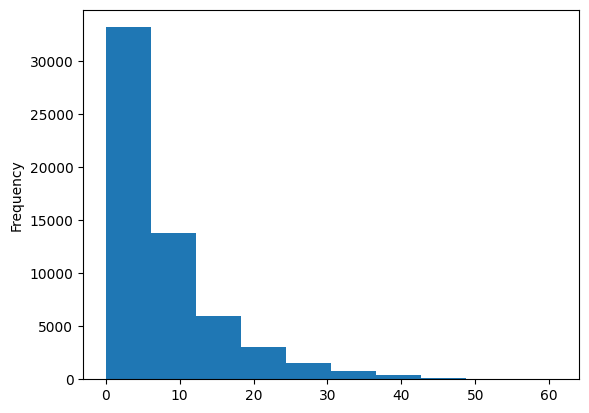

In [ ]:
# Distribution of stopwords visualy
temp['stop_words'].plot(kind='hist')

In [ ]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [ ]:
def lemmatization(text):
  lemmatizer = hazm.Lemmatizer()

  text = text.split()

  Text = [lemmatizer.lemmatize(y) for y in text]

  return " ".join(Text)

In [ ]:
def remove_stop_words(text):
  stop_words = get_stop_words()
  Text = [i for i in str(text).split() if i not in stop_words]
  return " ".join(Text)

In [ ]:
def cleaning(text):
  text = text.strip()

  # regular cleaning
  text = clean(text,
      fix_unicode=True,
      to_ascii=False,
      lower=True,
      no_line_breaks=True,
      no_urls=True,
      no_emails=True,
      no_phone_numbers=True,
      no_numbers=False,
      no_digits=False,
      no_currency_symbols=True,
      no_punct=False,
      replace_with_url="",
      replace_with_email="",
      replace_with_phone_number="",
      replace_with_number="",
      replace_with_digit="0",
      replace_with_currency_symbol=""
  )

  # Cleaning htmls
  text = cleanhtml(text)

  # Lemmatization
  text = lemmatization(text)

  # Clean stopwords
  text = remove_stop_words(text)

  # Normalizing
  normalizer = hazm.Normalizer()
  text = normalizer.normalize(text)

  # removing wierd patterns
  wierd_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u'\U00010000-\U0010ffff'
      u"\u200d"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u23cf"
      u"\u23e9"
      u"\u231a"
      u"\u3030"
      u"\ufe0f"
      u"\u2069"
      u"\u2066"
      # u"\u200c"
      u"\u2068"
      u"\u2067"
      "]+", flags=re.UNICODE)

  text = wierd_pattern.sub(r'', text)

  # removing extra spaces, hashtags
  text = re.sub('#', "", text)
  text = re.sub("\s+", " ", text)

  return text

In [ ]:
cleaning(data['comment'][100])

'کانال تاریخ صدر اسلام توضیح محمد حسین رجبی دوانی است. مفید بود. @rajabidavani_mohamadhosein'

In [ ]:
df_pos = data[data['label'] == 'positive']

df_neg = data[data['label'] == 'negative']

In [ ]:
df_pos = df_pos[:150]
df_neg = df_neg[:150]

In [ ]:
df = pd.concat([df_pos, df_neg], axis=0)
len(df)

300

In [ ]:
df = df.sample(frac=1)

In [ ]:
df.head()

,date,comment,bookname,rate,bookID,like,comment_len_by_words,label
253,1395/06/19,کسی نظر نداده فقط به این دلیل که فامیلیش شبیه ...,جاده بهشتیان,3.0,130.0,0.0,18.0,negative
134,1398/06/17,کتاب خیلی خوبیه اگه میخواین با عاشورای واقعی ا...,حماسه حسینی (جلد۱),5.0,75.0,7.0,36.0,positive
411,1395/05/24,این کتاب یکی از پرفروش ترین کتابهای نمایشگاه ک...,نورالدین پسر ایران,0.0,158.0,5.0,17.0,negative
109,1395/10/30,عالی بود ممنون از طاقچه \nانصافا چقدر دین اسلا...,جاذبه و دافعه علی (علیه السلام),5.0,72.0,1.0,28.0,positive
173,1395/04/10,خدا رحمت کنه آبت الله مطهری رو\nخیلی خوبه,سیری در سیره ائمه اطهار,5.0,81.0,0.0,9.0,positive


In [ ]:
# Cleaning comments
df['cleaned_comment'] = df['comment'].apply(cleaning)

# Calculate the length of comments based on their words
df['cleaned_comment_len_by_words'] = df['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# Remove comments with length of fewer than three words
df['cleaned_comment_len_by_words'] = df['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
df = df.dropna(subset=['cleaned_comment_len_by_words'])
df = df.reset_index(drop=True)

df.head()

,date,comment,bookname,rate,bookID,like,comment_len_by_words,label,cleaned_comment,cleaned_comment_len_by_words
0,1397/06/19,این چه وضعشه دیگه ؟ من این کتاب رو میخرم ، چرا...,حماسه حسینی (جلد۱),3.0,75.0,0.0,28.0,negative,این چه وضعشه دیگه؟ من این کتاب رو می‌خرم، چرا ...,28.0
1,1393/09/10,خیلی عالی دستتان درد نکند,داستان راستان (جلد ۱),5.0,57.0,1.0,5.0,positive,خیلی عالی دستتان درد نکند,5.0
2,1398/06/20,واقعا خیلی زشته که تو مملکت جمهوری اسلامی یه ع...,حماسه حسینی (جلد۱),5.0,75.0,3.0,49.0,positive,واقعا خیلی زشته که تو مملکت جمهوری اسلامی یه ع...,47.0
3,1397/10/20,بسیار زیباست و ارزش خوندن داره,جاذبه و دافعه علی (علیه السلام),5.0,72.0,4.0,6.0,positive,بسیار زیباست و ارزش خوندن داره,6.0
4,1395/06/16,من به همه توصیه میکنم این کتاب رو بخونند... \n...,ده گفتار,5.0,79.0,4.0,35.0,positive,من به همه توصیه می‌کنم این کتاب رو بخونند … من...,35.0


In [ ]:
df.to_csv("taaghche_cleaned.csv", header=True, index=False)

In [3]:
df = pd.read_csv("taaghche_cleaned.csv")

In [4]:
data = df[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,این چه وضعشه دیگه؟ من این کتاب رو می‌خرم، چرا ...,negative
1,خیلی عالی دستتان درد نکند,positive
2,واقعا خیلی زشته که تو مملکت جمهوری اسلامی یه ع...,positive
3,بسیار زیباست و ارزش خوندن داره,positive
4,من به همه توصیه می‌کنم این کتاب رو بخونند … من...,positive


In [5]:
def rate_to_label(rate, threshold=3.0):
  if rate <= threshold:
    return 'negative'
  else:
    return 'positive'

df['label'] = df['rate'].apply(lambda t: rate_to_label(t, 3.0))
labels = list(sorted(df['label'].unique()))
df.head()

,date,comment,bookname,rate,bookID,like,comment_len_by_words,label,cleaned_comment,cleaned_comment_len_by_words
0,1397/06/19,این چه وضعشه دیگه ؟ من این کتاب رو میخرم ، چرا...,حماسه حسینی (جلد۱),3.0,75.0,0.0,28.0,negative,این چه وضعشه دیگه؟ من این کتاب رو می‌خرم، چرا ...,28.0
1,1393/09/10,خیلی عالی دستتان درد نکند,داستان راستان (جلد ۱),5.0,57.0,1.0,5.0,positive,خیلی عالی دستتان درد نکند,5.0
2,1398/06/20,واقعا خیلی زشته که تو مملکت جمهوری اسلامی یه ع...,حماسه حسینی (جلد۱),5.0,75.0,3.0,49.0,positive,واقعا خیلی زشته که تو مملکت جمهوری اسلامی یه ع...,47.0
3,1397/10/20,بسیار زیباست و ارزش خوندن داره,جاذبه و دافعه علی (علیه السلام),5.0,72.0,4.0,6.0,positive,بسیار زیباست و ارزش خوندن داره,6.0
4,1395/06/16,من به همه توصیه میکنم این کتاب رو بخونند... \n...,ده گفتار,5.0,79.0,4.0,35.0,positive,من به همه توصیه می‌کنم این کتاب رو بخونند … من...,35.0


In [ ]:
print(f'We have #{len(labels)} labels: {labels}')

We have #2 labels: ['negative', 'positive']


## Hnading Unbalanced Data

In [ ]:
fig = go.Figure()

groupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
# negative_data = data[data['label'] == 'negative']
# positive_data = data[data['label'] == 'positive']

# cutting_point = min(len(negative_data), len(positive_data))

# if cutting_point <= len(negative_data):
#     negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

# if cutting_point <= len(positive_data):
#     positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

# new_data = pd.concat([negative_data, positive_data])
# new_data = new_data.sample(frac=1).reset_index(drop=True)
# new_data.info()

# Train, Validation, Test split

In [ ]:
data.shape

(297, 2)

In [6]:
data['label_id'] = data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(data, test_size=0.1, random_state=1, stratify=data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
valid = valid.reset_index(drop=True)

X_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
X_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()
X_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()


print(train.shape)
print(valid.shape)
print(test.shape)

(240, 3)
(27, 3)
(30, 3)


<ipython-input-6-20c68aae8a91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_id'] = data['label'].apply(lambda t: labels.index(t))


# Modeling

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
          VotingClassifier, AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
      accuracy_score, roc_curve)

import matplotlib.pyplot as plt
import seaborn as sns

## RandomForestClassifier

In [ ]:
RF = RandomForestClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=1
)

pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", RF)
])

pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=42, verbose=1))])

In [ ]:
# Train set accuracy
train_pred = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test set accuracy: ", test_accuracy)

RF_acc = test_accuracy

Train set accuracy:  1.0
Test set accuracy:  0.6666666666666666


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished


## SVC

In [ ]:
svm = SVC(kernel="linear", gamma=1, C=5, random_state=42)

svm_pipeline = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("svm", svm)
    ]
)

svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('svm', SVC(C=5, gamma=1, kernel='linear', random_state=42))])

In [ ]:
# Train set accuracy
train_pred = svm_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = svm_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test set accuracy: ", test_accuracy)

svm_acc = test_accuracy

Train set accuracy:  1.0
Test set accuracy:  0.6333333333333333


## LogistivRegression

In [ ]:
logistics = LogisticRegression(random_state=42, max_iter=1000)

logs_pipeline = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", logistics)
    ]
)

logs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
# Train set accuracy
train_pred = logs_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = logs_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test set accuracy: ", test_accuracy)

logs_acc = test_accuracy

Train set accuracy:  0.9958333333333333
Test set accuracy:  0.7


## NaiveBayes

In [ ]:
MNB = MultinomialNB()

MNB_pipeline = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", MNB)
    ]
)

MNB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [ ]:
# Train set accuracy
train_pred = MNB_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = MNB_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test set accuracy: ", test_accuracy)

MNB_acc = test_accuracy

Train set accuracy:  0.9583333333333334
Test set accuracy:  0.7


## GradientBoostingClassifier

In [ ]:
GB = GradientBoostingClassifier()

GB_pipeline = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", GB)
    ]
)

GB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', GradientBoostingClassifier())])

In [ ]:
# Train set accuracy
train_pred = GB_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = GB_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test set accuracy: ", test_accuracy)

GB_acc = test_accuracy

Train set accuracy:  0.9875
Test set accuracy:  0.5


## Best Model Implementation

<ipython-input-136-f7b1f40aeacc>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




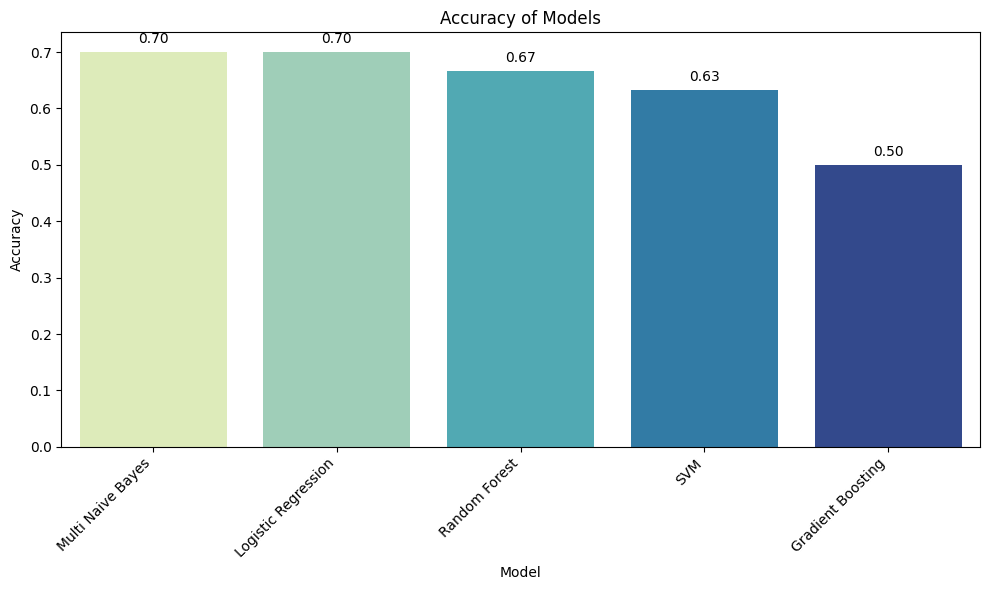

In [ ]:
accuracies = {
    "Multi Naive Bayes": MNB_acc,
    "SVM": svm_acc,
    "Random Forest": RF_acc,
    "Logistic Regression": logs_acc,
    "Gradient Boosting": GB_acc
}

# Sort accuracies in descending order
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract model names and accuracies
model_names = [model[0] for model in sorted_accuracies]
accuracy_values = [model[1] for model in sorted_accuracies]

# Create countplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=model_names, y=accuracy_values, palette="YlGnBu")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with is accuracy value
for i, v in enumerate(accuracy_values):
  ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ("MNB", MNB_pipeline),
    ("Logistic Regression", logs_pipeline),
    ("RF", pipeline)
]

voting_classifier = VotingClassifier(estimators=estimators, voting='hard')
voting_classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


VotingClassifier(estimators=[('MNB',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               GradientBoostingClassifier())])),
                             ('Logistic Regression',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))])),
                             ('RF',
                              Pipeline(steps=[('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               RandomForestClassifier(n_estimators=50,
                                                                      n_jobs=-1,
                                                                      random_state=42,
                                                                      verbose=1))]))])

In [ ]:
# Train set accuracy
train_pred = voting_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print('Train set accuracy: ', train_accuracy)

# Test set accuracy
test_pred = voting_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print("Test set accuracy: ", test_accuracy)

voting_acc = test_accuracy

Train set accuracy:  0.9958333333333333
Test set accuracy:  0.6666666666666666


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished


## Transformers

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

## Configuration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# General config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# Create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label
    }
)
print(config.to_json_string())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



## Input Embeddings

In [ ]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
در این حوزه کلی کتاب بهتر از این هست …
negative


In [ ]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Comment: {sample_comment}')
print(f' Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

 Comment: در این حوزه کلی کتاب بهتر از این هست …
 Tokens: در این حوزه کلی کتاب بهتر از این هست …
Token IDs: [2786, 2802, 3768, 3507, 3250, 4109, 2791, 2802, 2952, 1876]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt'
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
  print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[   2, 2786, 2802, 3768, 3507, 3250, 4109, 2791, 2802, 2952, 1876,    4,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


## Dataset

In [ ]:
class TaaghcheDataset(torch.utils.data.Dataset):
  """ Create a PyTorch dataset for Taaghche. """

  def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
    self.comments = comments
    self.targets = targets
    self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

    self.tokenizer = tokenizer
    self.max_len = max_len

    self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    comment = str(self.comments[item])

    if self.has_target:
      target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

    encoding = self.tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        truncation=True,
        max_length=self.max_len,
        return_token_type_ids=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    inputs = {
        'comment': comment,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'token_type_ids': encoding['token_type_ids'].flatten()
    }

    if self.has_target:
      inputs['targets'] = torch.tensor(target, dtype=torch.long)

    return inputs

In [ ]:
def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
  dataset = TaaghcheDataset(
      comments=x,
      targets=y,
      tokenizer=tokenizer,
      max_len=max_len,
      label_list=label_list,
  )

  return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), {}, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['اگر بخوایم بریم مثلا وسط کتاب یا صفحه\u200cی آخر کتاب بدون یکی یکی ورق زدن باید چیکار کنیم؟ راهی هست که بشه صفحه رو انتخاب کرد و ورق نزد؟ دوستان اگه میدونید راهنمایی کنید لطفا …', 'خیلی خوشم نیومد، اصولا نفهمیدم دلیل انتخاب این شهید برای کتاب نویسی در موردش چی بوده؟', 'سلام کتاب خوبیه ممنون طاقچه', 'با سلام. لطفا ۶ جلد کتاب نخل میثم استاد سازگار را هم قرار بدید. با تشکر', 'چه چرندیاتی رو رایگان کردی … همش چرته یا اینکه اون مورد خوبهاهم نصفش رو سانسور کردی\u200cای پاچه خورا', 'اینو حدودا راهنمایی بودم خوندم. مامانم شدیدا علاقه داشت که داستان راستان بخونیم چه دورانی بود، چقدرم احساس فرهیخته بودن بهم دست داده بود. یادش بخیر', 'در کل کتابهای شهید مطهری مورد تایید بزرگان است ولی محتوا و موضوع این کتاب بیشتر شرح وقایع تاریخی دوران امامت ائمه معصومین ع است، و پاسخ به بسیاری از شبهاتی که ممکن است مطرح شود. یک نمونه از شبهات، پاسخ به چراییه صلح امام حسن (ع) و قیام امام حسین (ع) و مقایسه\u200cی این دو، یا چراییه

In [ ]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


## Model

In [ ]:
class SentimentModel(nn.Module):
  def __init__(self, config):
    super(SentimentModel, self).__init__()

    self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, input_ids, attention_mask, token_type_ids):
    _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        return_dict=False
    )

    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Mon Dec 16 15:06:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

pt_model <class '__main__.SentimentModel'>


In [ ]:
# Sample data output
sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# Available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[ 0.3071,  0.1264],
        [ 0.5507,  0.1323],
        [ 0.3961, -0.1322],
        [ 0.3529, -0.1162],
        [ 0.7325, -0.0552]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0, 0, 0, 0, 0], device='cuda:0')


## Training

In [ ]:
def simple_accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
  acc = simple_accuracy(y_true, y_pred)
  f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
  return {
      "acc": acc,
      "f1": f1
  }

def y_loss(y_true, y_pred, losses):
  y_true = torch.stack(y_true).cpu().detach().numpy()
  y_pred = torch.stack(y_pred).cpu().detach().numpy()
  y = [y_true, y_pred]
  loss = np.mean(losses)

  return y, loss

def eval_op(model, data_loader, loss_fn):
  model.eval()

  losses = []
  y_pred = []
  y_true = []

  with torch.no_grad():
    for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

      input_ids = dl['input_ids']
      attention_mask = dl['attention_mask']
      token_type_ids = dl['token_type_ids']
      targets = dl['targets']

      # Move tensors to GPU if CUDA is available
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      token_type_ids = token_type_ids.to(device)
      targets = targets.to(device)

      # Compute predicted outputs by passing inputs to the model
      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )

      # Convert output probabilities to predicted class
      _, preds = torch.max(outputs, dim=1)

      # Calculate the batch loss
      loss = loss_fn(outputs, targets)

      # Accumulate all losses
      losses.append(loss.item())

      y_pred.extend(preds)
      y_true.extend(targets)

  eval_y, eval_loss = y_loss(y_true, y_pred, losses)
  return eval_y, eval_loss

def train_op(model,
             data_loader,
             loss_fn,
             optimizer,
             scheduler,
             step=0,
             print_every_step=100,
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None,
             clip=0.0):

  model.train()

  losses = []
  y_pred = []
  y_true = []

  for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
    step += 1
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']

    # Move tensors to GPU if CUDA is available
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)

    # Clear the gradients of all optimized variables
    optimizer.zero_grad()

    # Compute predicted outputs by passing inputs to the model
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )

    # Convert output probabilities to predicted class
    _, preds = torch.max(outputs, dim=1)

    # Calculate the batch loss
    loss = loss_fn(outputs, targets)

    # Accumulate all the losses
    losses.append(loss.item())

    # Compute gradient of the loss with respect to model parameters
    loss.backward()

    # 'clip_grad_norm' helps prevent the ecploding gradientproblem in RNNs / LSTMs.
    if clip > 0.0:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

    # Perform optimization step
    optimizer.step()

    # Perform schedular step
    scheduler.step()

    y_pred.extend(preds)
    y_true.extend(targets)

    if eval:
      train_y, train_loss = y_loss(y_true, y_pred, losses)
      train_score = acc_and_f1(train_y[0], train_y[1], average="weighted")

      if step % print_every_step == 0:
        eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
        eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

        if hasattr(eval_cb, '__call__'):
          eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

  train_y, train_loss = y_loss(y_true, y_pred, losses)

  return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)

def eval_callback(epoch, epochs, output_path):
  def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_los_min):
    statement = ''
    statement += 'Epoch: {}/{}...'.format(epoch, epochs)
    statement += 'Step: {}...'.format(step)

    statement += 'Train Loss: {:.6f}...'.format(train_loss)
    statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])


    statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
    statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

    print(statement)

    if eval_loss <= eval_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
          eval_loss_min,
          eval_loss
      ))

      torch.save(model.state_dict(), output_path)
      eval_loss_min = eval_loss

    return eval_loss_min

  return eval_cb


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
  train_y, train_loss, step, eval_loss_min = train_op(
      model=pt_model,
      data_loader=train_data_loader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      scheduler=scheduler,
      step=step,
      print_every_step=EEVERY_EPOCH,
      eval=True,
      eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
      eval_loss_min=eval_loss_min,
      eval_data_loader=valid_data_loader,
      clip=CLIP
  )

  train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
  eval_y, eval_loss = eval_op(
      model=pt_model,
      data_loader=valid_data_loader,
      loss_fn=loss_fn
  )

  eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

  history['train_acc'].append(train_score['acc'])
  history['train_loss'].append(train_loss)
  history['val_acc'].append(eval_score['acc'])
  history['val_loss'].append(eval_loss)

Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/2 [00:00<?, ?it/s]

Training... :   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/2 [00:00<?, ?it/s]

Training... :   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/2 [00:00<?, ?it/s]

## Prediction

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
  data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)

  predictions = []
  prediction_probs = []

  model.eval()
  with torch.no_grad():
    for dl in tqdm(data_loader, position=0):
      input_ids = dl['input_ids']
      attention_mask = dl['attention_mask']
      token_type_ids = dl['token_type_ids']

      # Move tensors to GPU if CUDA is available
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      token_type_ids = token_type_ids.to(device)

      # Compute predicted outputs by passing inputs to the model
      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )

      # Convert output probabilities to predicted class
      _, preds = torch.max(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(F.softmax(outputs, dim=1))

  predictions = torch.stack(predictions).cpu().detach().numpy()
  prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

  return predictions, prediction_probs


In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

(30,) (30, 2)


In [ ]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.6996662958843161

              precision    recall  f1-score   support

    negative       0.69      0.73      0.71        15
    positive       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

